In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import get_config

In [2]:
num_paths = 10952

In [3]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        print(((f"{config.forcing_const}FConst").replace(".","")))
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [4]:
config = get_config()
global_files, true_files, local_files, bws = get_drift_files(config=config)
local_files

075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst
075FConst


['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_000012626bw_10952NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_000015943bw_10952NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_00002013bw_10952NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_000025417bw_10952NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_000032093bw_10952NPaths_00t0_3906e-03dT_07

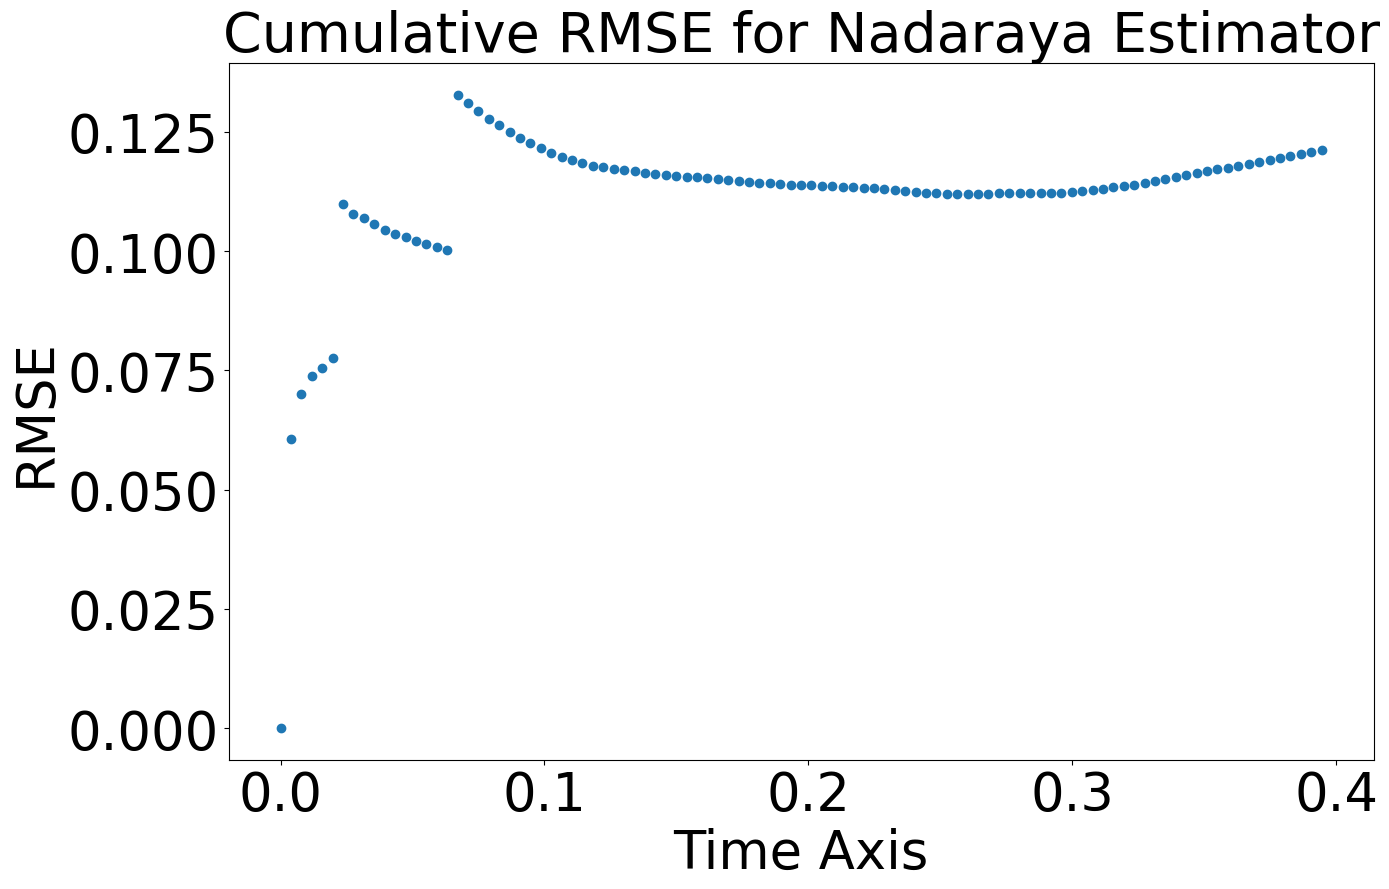

Final time cumulative RMSE local-time error 0.12111063302685539 at bw 1e-05 for 0.75FConst



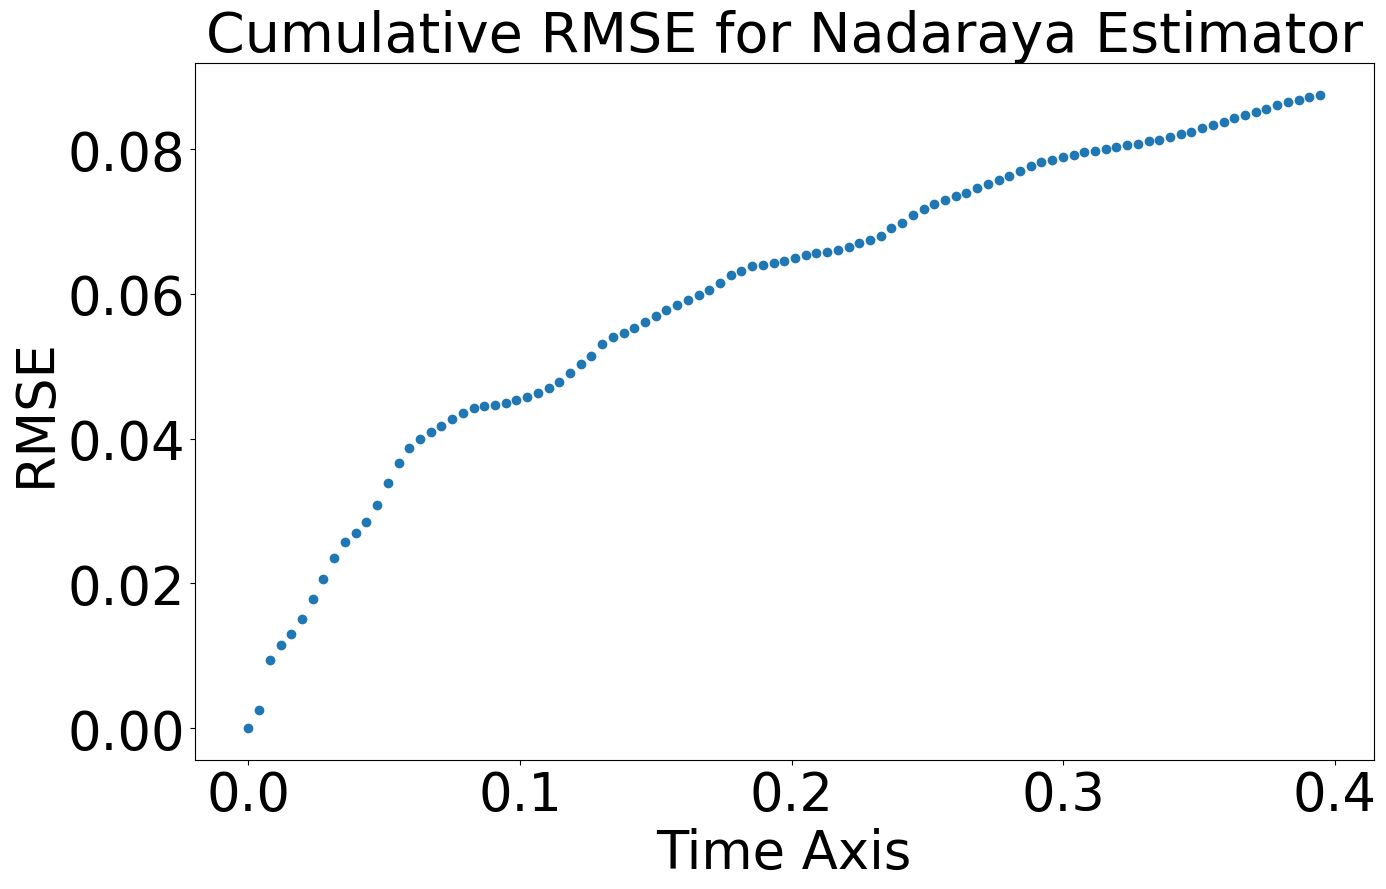

Final time cumulative RMSE local-time error 0.08754882424272256 at bw 0.010926009 for 0.75FConst



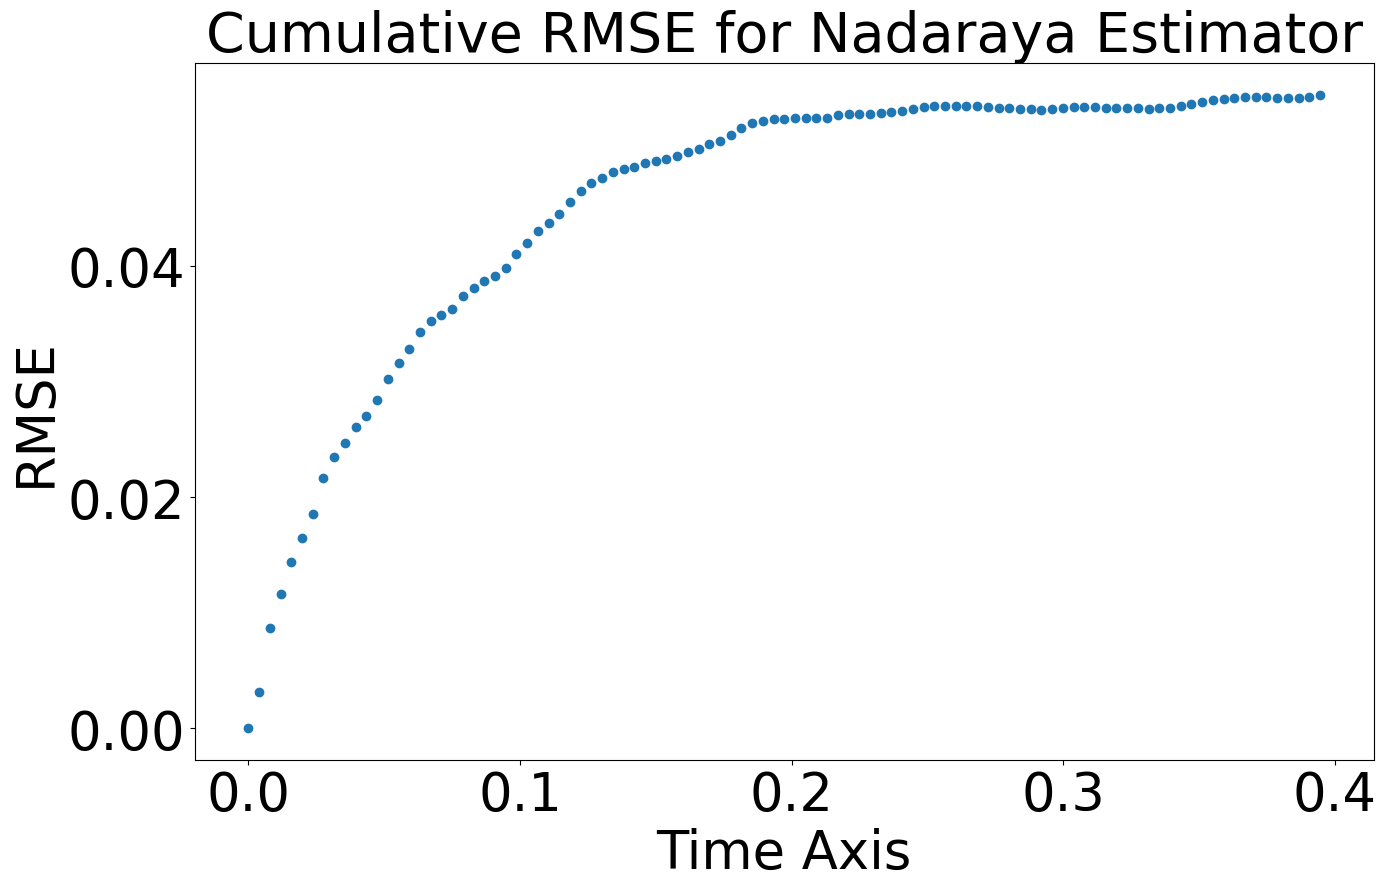

Final time cumulative RMSE local-time error 0.05482927922537974 at bw 0.013795695 for 0.75FConst



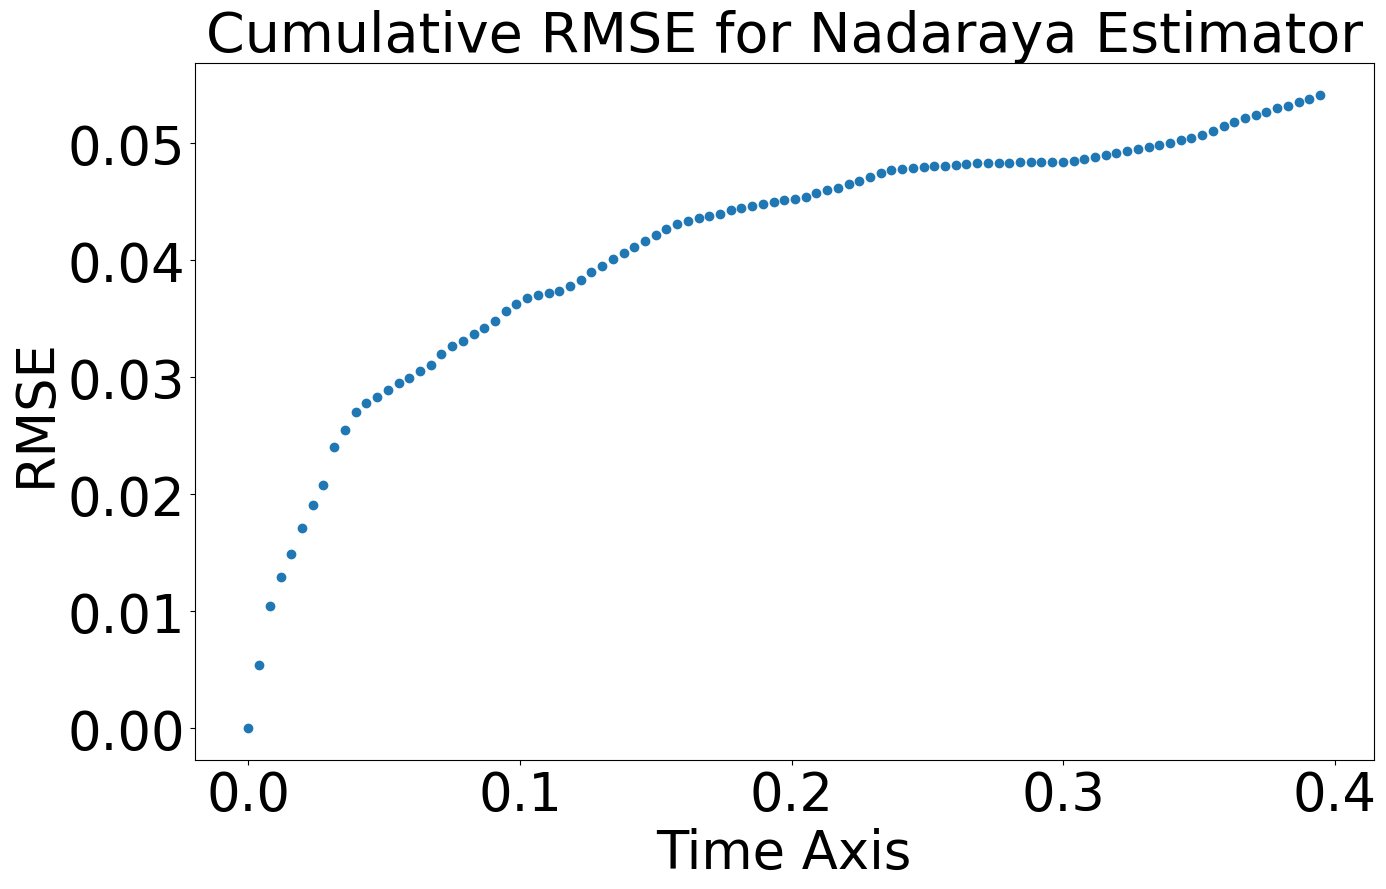

Final time cumulative RMSE local-time error 0.054147813127365406 at bw 0.021994176 for 0.75FConst



In [5]:
curr_rmse = np.inf
for file in zip(*[true_files, global_files, local_files, bws]):
    bw = file[-1]
    true_states = np.load(file[0])/np.sqrt(config.deltaT)
    local_states = np.load(file[2])/np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    if total_local_errors[-1] < curr_rmse:
        curr_rmse = total_local_errors[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
        ax.set_title(f"Cumulative RMSE for Nadaraya Estimator",fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at bw {bw} for {config.forcing_const}FConst\n")